# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__
1) Which living outcome do housing conditions affect the most (education, health or happiness)?

2) Is there a correlation between precarious housing and health (both physical and mental) status?

3) In what ways do living conditions affect children scholarship (if they do) ? Which age group is most impacted ?


## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from math import exp, log
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [13]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [14]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','RESPID','UCPSID','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
#education = ['CCHGSC','CSUEXP','CATTSC','CSKIPSC','CGETBY','CHMWK','CINTSC','CWRKSC','UENG','UENGNEG','UENGPOS']
education = ['UENG','UENGNEG','UENGPOS']
#family = ['GHMAD','GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family = ['UFAMSTR','UMH2','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','CAGRAD','GHEADS','KAPPMED','SSHELP']
programs_hh = ['MPUBHOUS']
eco = ['CJOB','UHINS4'] #NB CJOB only for fc3

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs + eco]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh + programs_hh]

In [41]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the CJOB variable binary with Yes=1 and No=0
child['CJOB'].replace(2,0)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,CJOB,UHINS4,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,MPUBHOUS
0,5561612801,1,5561612803,5561612800,1,3,15,WI,2,A1,...,-1,2,2,0,3,1,4,1,0.75,-1
1,5470400001,2,5470400003,5470400000,0,14,15,WI,2,A1,...,2,1,0,2,3,2,2,2,1.50,-1
2,5787427204,2,5787427205,5787427200,1,9,15,WI,2,A1,...,-1,2,0,4,6,1,3,2,2.00,2
3,5410681601,1,5410681604,5410681600,0,4,15,WI,2,A1,...,-1,2,3,0,5,1,2,2,2.50,2
4,5051721601,2,5051721605,5051721600,1,17,15,WI,2,A1,...,1,2,0,4,5,1,4,2,1.25,1


In [42]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# FC1 : focal child, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal child, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal child, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal child, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [17]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 56)
fc2: (10925, 56)
fc3:(11087, 56)
fc23: (22012, 56)
True


## Data visualization

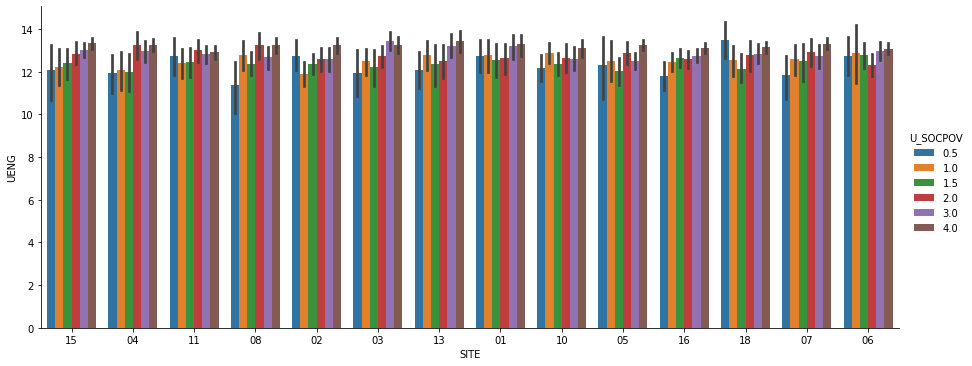

In [7]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc2, height=5, aspect=2.5)

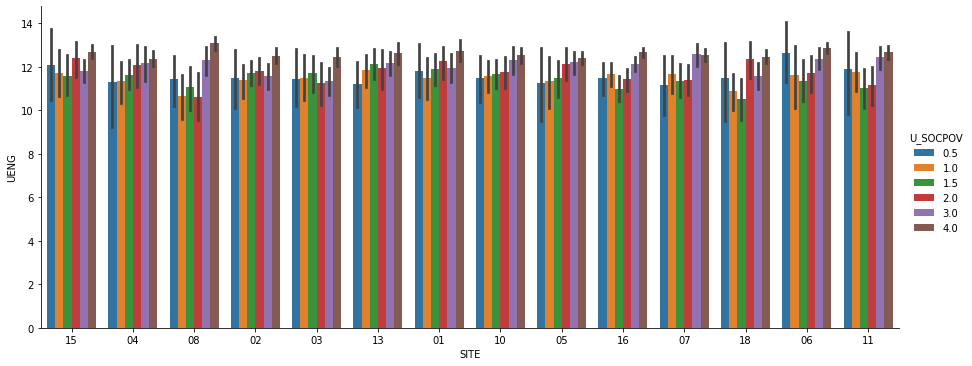

In [8]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc3, height=5, aspect=2.5)

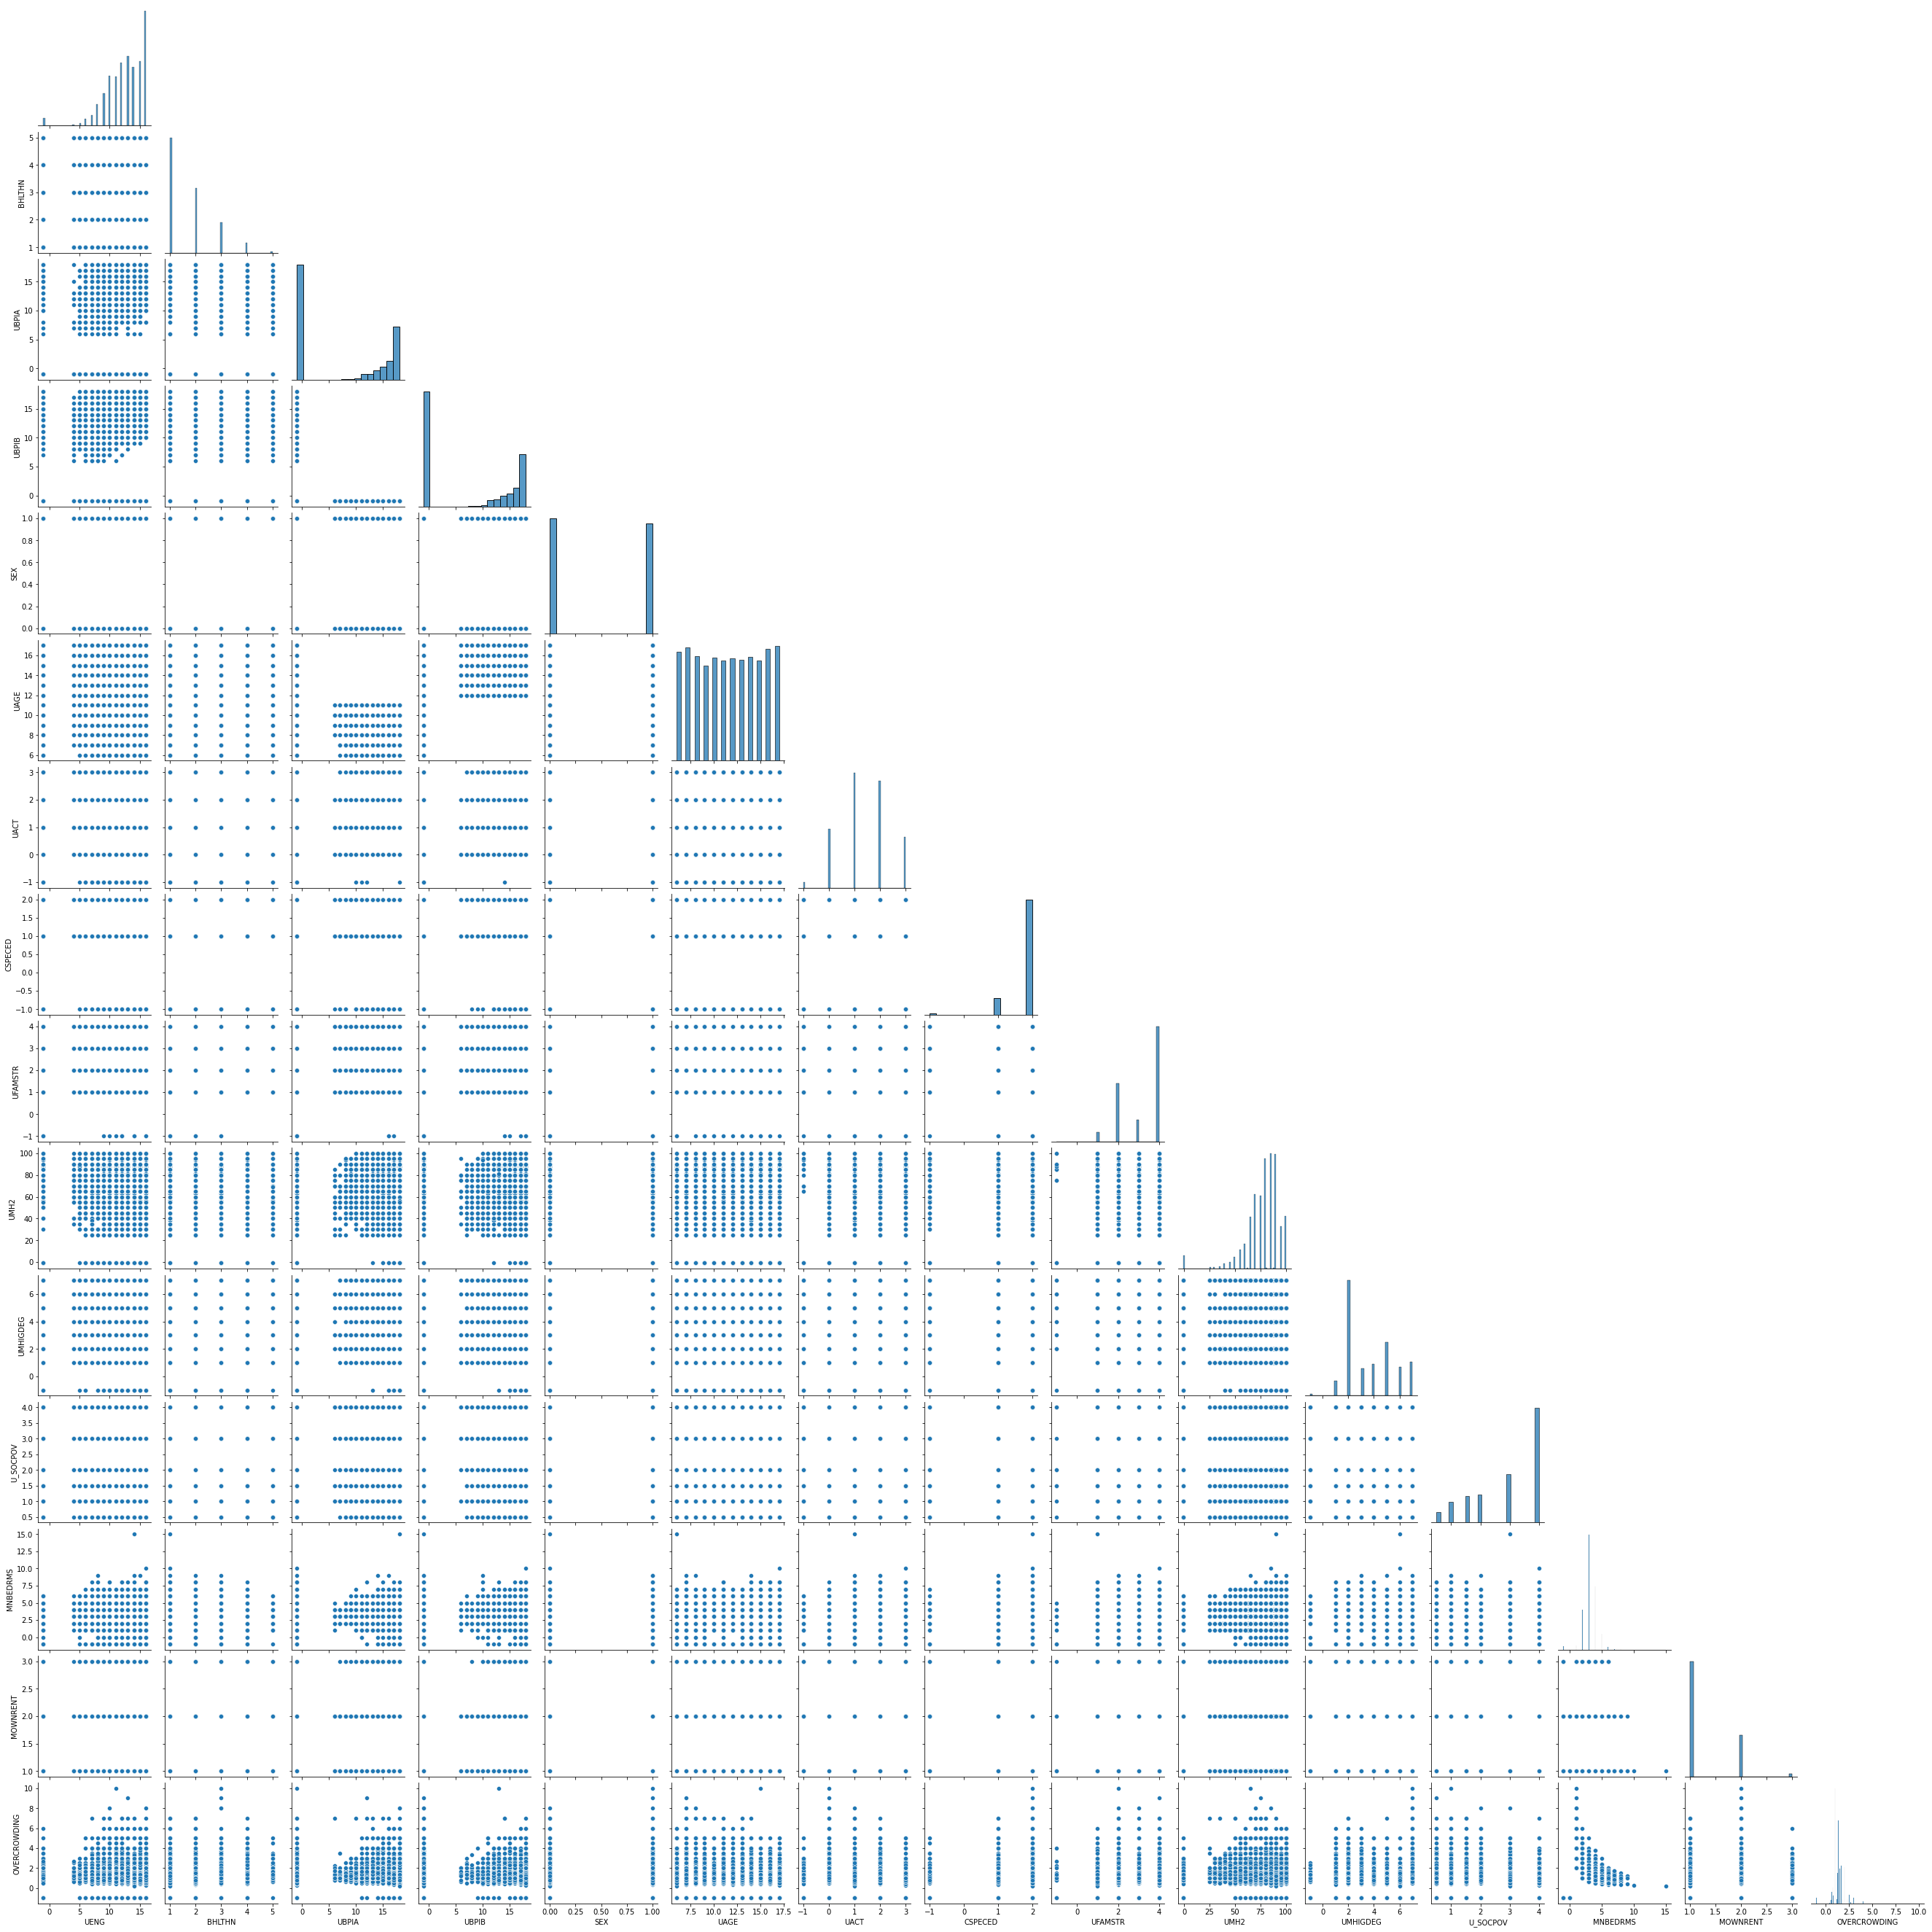

In [9]:
#sns.pairplot(fc23[['UENG','BHLTHN','UBPIA','UBPIB','SEX','UAGE','UACT','CSPECED']+family+income+housing_hh], corner=True)

## Propensity score attempt

__Living conditions indicator :__

In [18]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [43]:
# Variables used for precarity indicator (economics and relationship with family)
# NB CHOICE OF WORDS : PRECARITY NOT VERY ACCURATE
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']
prec3 = prec + ['CJOB']

# IL FAUDRA DECIDER DE COMMENT GERER LES NANS SUR CES VALEURS POUR DEFINIR L'INDEX

df_prec_2 = df_NN(fc2,'PERSID',prec)
df_prec_3 = df_NN(fc3,'PERSID',prec3)

In [50]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
negative3 = negative + ['CJOB']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them -> WE CAN CHOOSE WEIGHTS LATER TO TUNE THE INDEX
# NB performs column-wise automatically
norm_prec_2 =(df_prec_2[prec]-df_prec_2[prec].min())/(df_prec_2[prec].max()-df_prec_2[prec].min())
norm_prec_3 =(df_prec_3[prec3]-df_prec_3[prec3].min())/(df_prec_3[prec3].max()-df_prec_3[prec3].min())
norm_prec_2.loc[:,negative] *= -1
norm_prec_3.loc[:,negative3] *= -1

# Compute living conditions indicator
norm_prec_2.loc[:,'living_ind'] = norm_prec_2.sum(axis=1)
norm_prec_3.loc[:,'living_ind'] = norm_prec_3.sum(axis=1)

In [59]:
print(f"fc2:\n {norm_prec_2['living_ind'].describe()} \n\nfc3:\n {norm_prec_3['living_ind'].describe()}")

fc2:
 count    10665.000000
mean         1.757094
std          0.890806
min         -1.348485
25%          1.090909
50%          1.928571
75%          2.566558
max          2.974026
Name: living_ind, dtype: float64 

fc3:
 count    10824.000000
mean         1.111086
std          1.078990
min         -2.314188
25%          0.322042
50%          1.261168
75%          1.844502
max          2.969072
Name: living_ind, dtype: float64


In [66]:
# Choose a threshold to consider a household 'precarious' or not -> ADAPT (j'ai juste pris zero en mode random)
norm_prec_2.loc[:,'precarious'] = norm_prec_2['living_ind'].apply(lambda x : 0 if x < 0 else 1)
norm_prec_3.loc[:,'precarious'] = norm_prec_3['living_ind'].apply(lambda x : 0 if x < 0 else 1)

# Merge this new column with whole df without NaNs
fc2_prec = pd.merge(fc2, norm_prec_2['precarious'], left_index=True, right_index=True, how='inner')
fc3_prec = pd.merge(fc3, norm_prec_3['precarious'], left_index=True, right_index=True, how='inner')

In [71]:
fc2_prec.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,UHINS4,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,MPUBHOUS,precarious
2,5787427204,2,5787427205,5787427200,1,9,15,WI,2,A1,...,2,0,4,6,1,3,2,2.000000,2,1
6,5353539201,2,5353539204,5353539200,1,11,15,WI,2,A1,...,4,2,1,9,2,4,2,2.250000,2,1
13,5442400001,2,5442400007,5442400000,0,11,15,WI,2,A1,...,2,3,3,8,1,3,2,2.666667,2,1
21,5851446401,2,5851446402,5851446400,0,7,15,WI,2,A1,...,2,0,1,2,1,2,2,1.000000,2,1
22,5047936001,2,5047936005,5047936000,1,8,15,WI,2,A1,...,3,3,1,5,1,3,2,1.666667,2,0


__Logistic regression and propensity score :__

In [81]:
# Perform logistic regression
log_model_2 = 'precarious ~ SEX + UAGE + UREGION + UENG + UFAMSTR + UMH2 + UMHIGDEG + UAGG + CHLD0_5 + CHLD6_17 \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + UBPIA + BDISBL + BHLTHN + UACT + CSPECED + UHINS4'

log_model_3 = 'precarious ~ SEX + UAGE + UREGION + UENG + UFAMSTR + UMH2 + UMHIGDEG + UAGG + CHLD0_5 + CHLD6_17 \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + UBPIB + BDISBL + BHLTHN + UACT + CSPECED + UHINS4 \
+ C(CJOB)'

log2 = smf.logit(formula=log_model_2, data=fc2_prec)
res2 = log2.fit(method='bfgs')  #J'AI MIS CETTE METHODE RANDOM PCQ SINON ÇA COMPILAIT PAS MAIS JSP CE QUE C'EST
log3 = smf.logit(formula=log_model_3, data=fc3_prec)
res3 = log3.fit(method='bfgs')

         Current function value: 0.010100
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


//anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.032307
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


//anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                10665
Model:                          Logit   Df Residuals:                    10641
Method:                           MLE   Df Model:                           23
Date:                Fri, 04 Dec 2020   Pseudo R-squ.:                  0.9317
Time:                        00:29:25   Log-Likelihood:                -107.72
converged:                      False   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.8301      2.588     -0.321      0.748      -5.902       4.241
UREGION[T.2]     1.0709      0.707      1.515      0.130      -0.314       2.456
UREGION[T.3]    -0.8103      0.552     -1.469      0.142      -1.891       0.271
UREGION[T.4]     0.6367      0.621      1.026      0.305      -0.580       1.853
SEX              0.4590      0.422      1.087      0.277      -0.368       1.286
UAGE            -0.3829      0.131     -2.922      0.003      -0.640      -0.126
UENG             0.0624      0.085      0.735      0.463      -0.104       0.229
UFAMSTR         12.6638      1.361      9.304      0.000       9.996      15.332
UMH2             0.0336      0.013      2.499      0.012       0.007       0.060
UMHIGDEG         0.0343      0.089      0.387      0.699      -0.139       0.208
UAGG             3.2935      0.369      8.935      0.000       2.571       4.016
CHLD0_5         -1.2047      0.367     -3.283      0.001      -1.924      -0.486
CHLD6_17        -0.8847      0.351     -2.523      0.012      -1.572      -0.197
UHHCOUNT         0.0470      0.353      0.133      0.894      -0.646       0.740
U_SOCPOV        11.4130      1.245      9.164      0.000       8.972      13.854
MNBEDRMS         0.3972      0.572      0.694      0.488      -0.725       1.519
MOWNRENT       -15.3675      1.663     -9.239      0.000     -18.628     -12.107
OVERCROWDING    -4.2225      0.673     -6.276      0.000      -5.541      -2.904
UBPIA           -0.1830      0.107     -1.717      0.086      -0.392       0.026
BDISBL          -0.6790      0.508     -1.335      0.182      -1.676       0.318
BHLTHN          -0.1676      0.197     -0.849      0.396      -0.554       0.219
UACT            -0.2777      0.263     -1.057      0.291      -0.793       0.237
CSPECED         -1.3311      0.381     -3.490      0.000      -2.079      -0.584
UHINS4         -12.1935      1.308     -9.325      0.000     -14.757      -9.631
================================================================================

Possibly complete quasi-separation: A fraction 0.95 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

outcome = 'UENG'
predictors = ['UFAMSTR','UMH2','OVERCROWDING']
df_noNull = df_NN(child,outcome,predictors)
glm = sm.GLM(df_noNull[outcome].values, df_noNull[predictors].replace(2,0).values)
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                21257
Model:                            GLM   Df Residuals:                    21254
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          9.4376
Method:                          IRLS   Log-Likelihood:                -54019.
Date:                Thu, 03 Dec 2020   Deviance:                   2.0059e+05
Time:                        19:19:59   Pearson chi2:                 2.01e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2112      0.012     17.453      0.000       0.187       0.235
x2             0.1404      0.001    221.699      0.000       0.139       0.142
x3             0.6530      0.031     21.348      0.000       0.593       0.713
==============================================================================
"""

In [12]:
res.predict(df_noNull[predictors].replace(2,0).values)

array([11.50727049, 14.67058883,  6.99255008, ..., 15.32361062,
       12.56416012, 11.48697264])

In [13]:
deltas = res.predict(df_noNull[predictors].replace(2,0).values) - df_noNull[outcome].values
print(deltas.mean(),deltas.std())
# mauvaises predictions -> GLM meh

-0.24418887689282026 3.0621341863427425


In [14]:
reg = RandomForestRegressor()
X = df_noNull[predictors].replace(2,0).values.reshape(1,-1)
y = df_noNull[outcome].values.reshape(1,-1)
reg.fit(X, y)
reg.predict(X)-y #=array(0) si le RFR a marché

array([[0., 0., 0., ..., 0., 0., 0.]])

## Linear regression models

In [15]:
# returns a regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit, cluster std based on state        
    return smf.ols(formula=model, data=df_reg).fit(cov_type='cluster',cov_kwds={'groups': df_reg['STATE']})

## Education

In [16]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     1264.
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           4.21e-57
Time:                        19:19:59   Log-Likelihood:                -49336.
No. Observations:               21101   AIC:                         9.870e+04
Df Residuals:                   21089   BIC:                         9.879e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.7539      0.233     33.220   

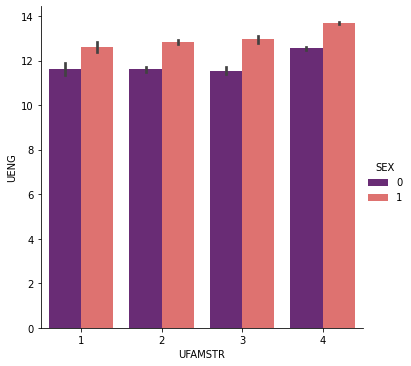

In [17]:
sns.catplot(y='UENG', x='UFAMSTR', hue='SEX', kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

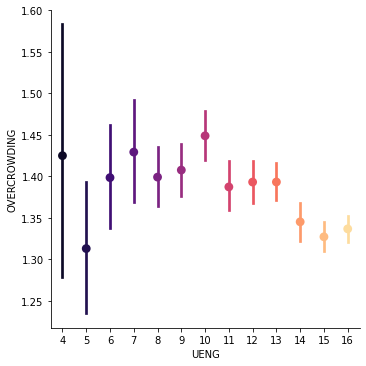

In [18]:
sns.catplot(x='UENG', y='OVERCROWDING',kind='point', palette='magma', data=df_NN(fc23,outcome,predictors))

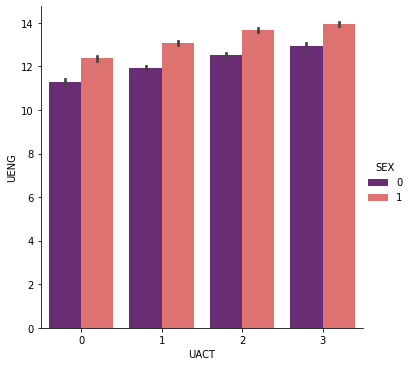

In [19]:
sns.catplot(y='UENG', x='UACT', hue='SEX', kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

## Health

In [20]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     250.9
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           4.13e-39
Time:                        19:20:02   Log-Likelihood:                -27037.
No. Observations:               21487   AIC:                         5.410e+04
Df Residuals:                   21476   BIC:                         5.418e+04
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.7792      0.088     31.535   

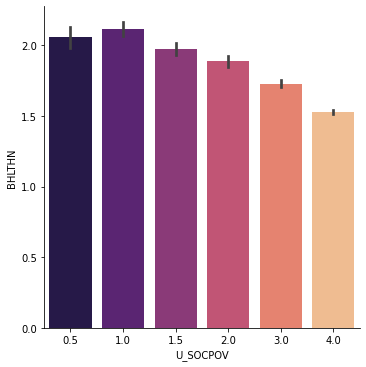

In [21]:
sns.catplot(y='BHLTHN', x='U_SOCPOV',kind='bar',palette='magma', data=df_NN(fc23,outcome,predictors))

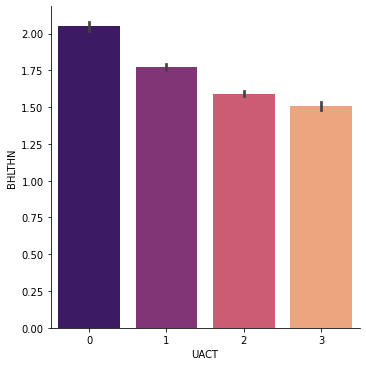

In [22]:
sns.catplot(y='BHLTHN', x='UACT',kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

## Mental health


**fc2**


In [23]:
outcome = 'UBPIA'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     200.6
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           9.66e-37
Time:                        19:20:04   Log-Likelihood:                -21920.
No. Observations:               10588   AIC:                         4.386e+04
Df Residuals:                   10577   BIC:                         4.394e+04
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.8361      0.233     50.741   

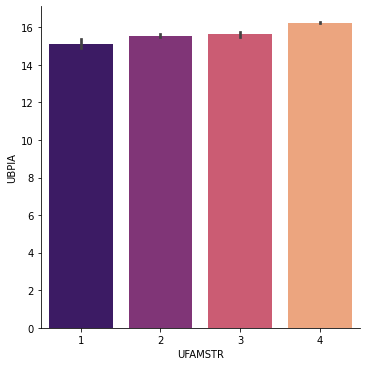

In [24]:
sns.catplot(y='UBPIA', x='UFAMSTR', kind='bar', palette='magma', data=df_NN(fc2,outcome,predictors))

**fc3**

In [25]:
outcome = 'UBPIB'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc3,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     213.6
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           2.10e-37
Time:                        19:20:04   Log-Likelihood:                -22944.
No. Observations:               10801   AIC:                         4.591e+04
Df Residuals:                   10790   BIC:                         4.599e+04
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.1457      0.254     40.010   

In [26]:
df_noNull = df_NN(fc3,outcome, predictors)
xtest = df_noNull[predictors]
diff = (res.predict(xtest) - df_noNull['UBPIB'])
print(diff.mean(),diff.std())
#error is normally distributed -> good, but the low r squared gives a rather high std

-3.768652622429103e-15 2.0246173097543854


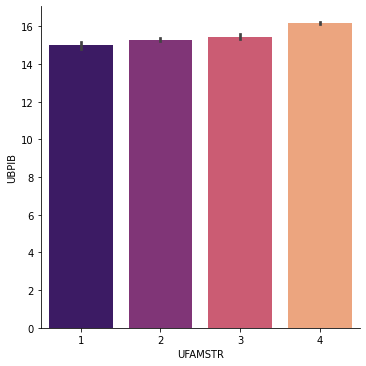

In [27]:
sns.catplot(y='UBPIB', x='UFAMSTR', kind='bar', palette='magma', data=df_NN(fc3,outcome,predictors))

## Conclusion Q1

Looking at the whole model, we can say that mental health is most influenced by housing conditions.

## Mental health of UMH2

In [28]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     44.53
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           2.55e-19
Time:                        19:20:05   Log-Likelihood:            -1.3349e+05
No. Observations:               33553   AIC:                         2.670e+05
Df Residuals:                   33545   BIC:                         2.671e+05
Df Model:                           7                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       72.4220      0.783     92.483   

In [29]:
outcome = 'UENGNEG'
predictors = ['UFAMSTR']
df_noNull = df_NN(fc23,outcome, predictors)

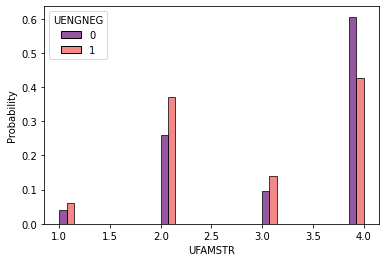

In [31]:
sns.histplot(x='UFAMSTR', hue='UENGNEG', stat='probability', data=df_noNull, common_norm=False,
             multiple='dodge', palette='magma')
# dans quelles familles sont distribués les gars mauvais